# Train Object Colors

In [3]:
from collections import namedtuple
from IPython.display import display

import numpy as np


import matplotlib.pyplot as plt

import torch
import source.tensorize as t
import torch.optim as optim 
import torch.nn.functional as F
from source.scene import *
from source.renderer import *

%load_ext autoreload
%autoreload 2

### Ground Truth and Initial Guess

Remember the trainable quantities are the scene parameters.  

In [82]:
experiment = 'color_test_2'
true_scene = parse_scene('./scenes/%s.ground_truth.yaml' % experiment)
pred_scene = parse_scene('./scenes/%s.init1.yaml' % experiment)


Now create the images and display the initialization:

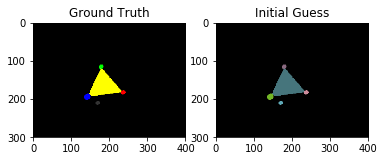

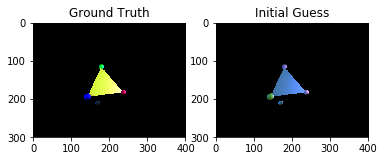

In [83]:
true_renderer = FlatRenderer(true_scene)
true_image = true_renderer.forward()
true_image.show_image('albedo', title='Ground Truth', subplot='121')

pred_renderer = FlatRenderer(pred_scene)
pred_image = pred_renderer.forward()
pred_image.show_image('albedo', title='Initial Guess', subplot='122')
plt.show()

true_phong_renderer = PhongRenderer(true_scene)
true_phong_image = true_phong_renderer.forward()
true_phong_image.show_image('albedo', title='Ground Truth', subplot='121')

pred_phong_renderer = PhongRenderer(pred_scene)
pred_phong_image = pred_phong_renderer.forward()
pred_phong_image.show_image('albedo', title='Initial Guess', subplot='122')
plt.show()
          

### Todo: A smart loss function for the camera parameters...

In [90]:
def train(ground_truth, renderer, subsampling=False, image_type='depth', iterations = 20):
    suffix = "with subsampling" if subsampling else "without subsampling"
    print("Training a {0} regarding a {1} image ".format(renderer.__class__.__name__, image_type) + suffix)
    loss_history = []
    
    renderer.set_trainable({'tri_1': ['color'], 'ball_middle': ['color'], 'ball_right': ['color'], 'ball_front': ['color'], 'ball_up': ['color']})
    params  = filter(lambda p: p.requires_grad, renderer.parameters())
    optimizer = optim.Adam(params, lr=.1)

    for _ in range(iterations):
    
        renderer.clear()
        optimizer.zero_grad()

        prediction = renderer.forward(subsampling)
        loss = F.mse_loss(ground_truth.get_image('albedo'), prediction.get_image('albedo'))
        loss.backward()
        optimizer.step()


        #history of intermediate losses and images 
        loss_history.append(t.detach_numpy(loss))

        if _ % (iterations/10) == 0:
            ground_truth.show_image('albedo', title='Ground Truth:', subplot='121')
            prediction.show_image('albedo', title='Guess {0}:'.format(_), subplot='122')
            plt.show()
    
    
    _ = np.arange(iterations)
    plt.plot(_, loss_history, label='loss')
    plt.xticks(_)
    plt.legend()
    plt.show()


Training a FlatRenderer regarding a depth image without subsampling


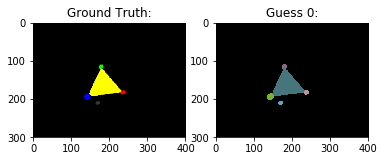

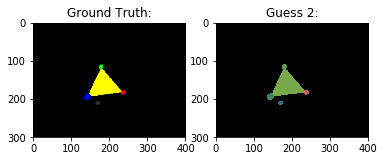

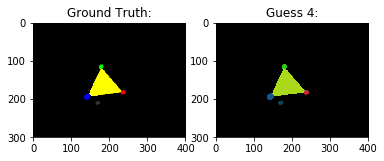

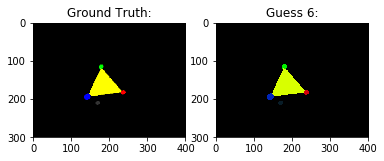

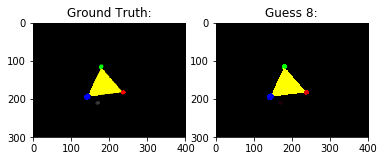

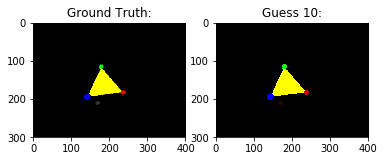

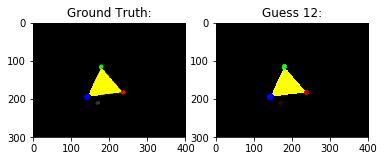

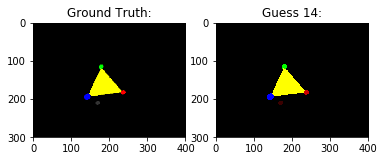

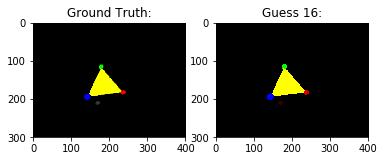

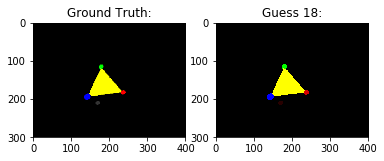

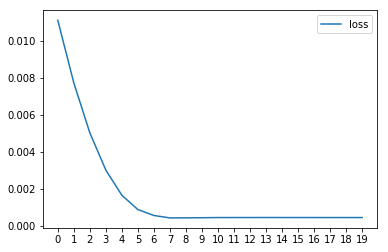

Training a FlatRenderer regarding a depth image with subsampling


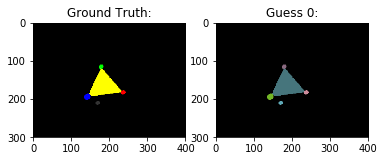

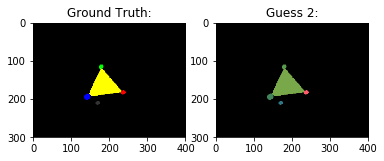

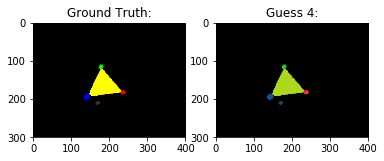

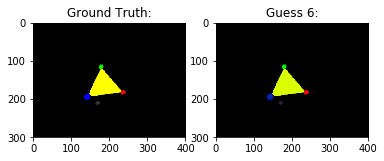

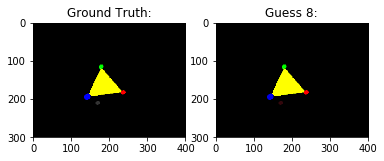

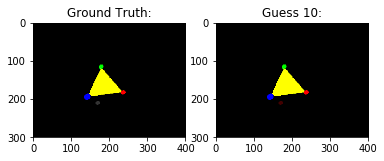

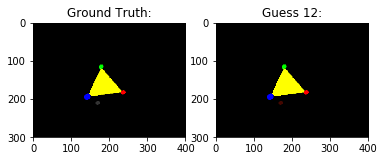

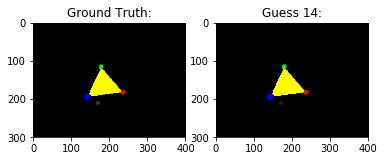

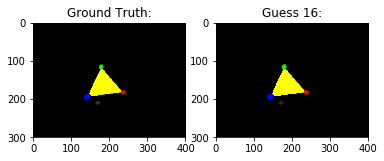

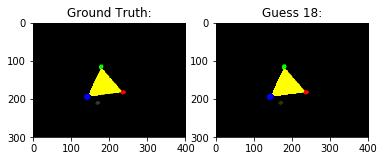

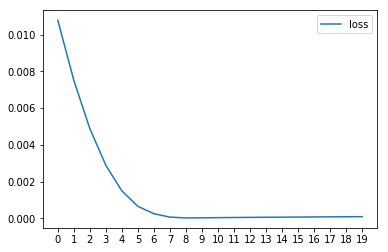

Training a PhongRenderer regarding a depth image without subsampling


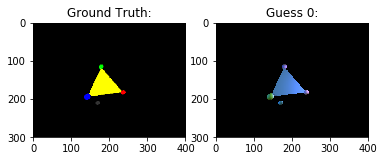

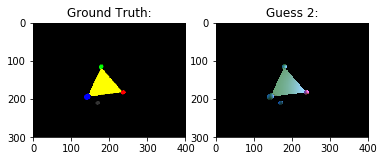

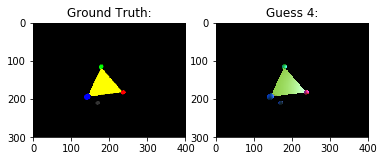

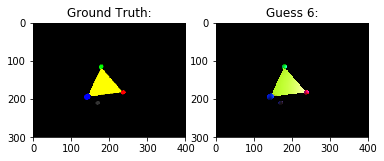

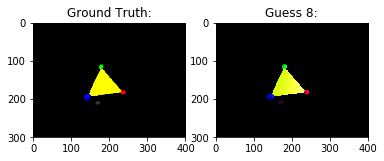

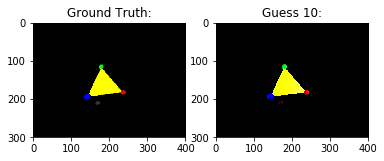

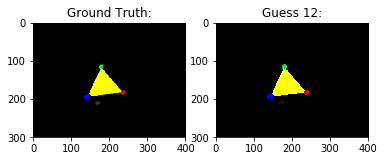

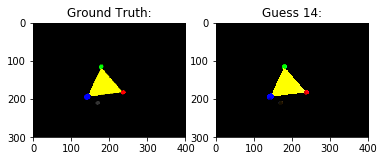

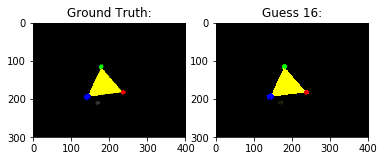

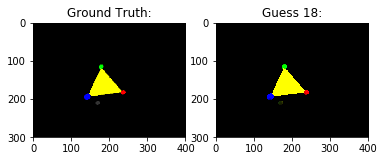

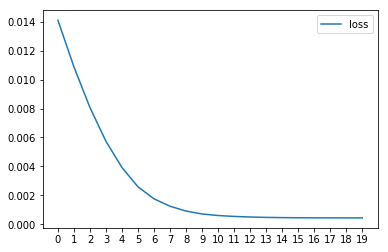

In [91]:
flat_renderer = FlatRenderer(pred_scene)
flat_renderer_sub = FlatRenderer(pred_scene)
phong_renderer = PhongRenderer(pred_scene)

train(true_image, flat_renderer, subsampling=False)
train(true_image, flat_renderer_sub, subsampling=True)
train(true_image, phong_renderer, subsampling=False)


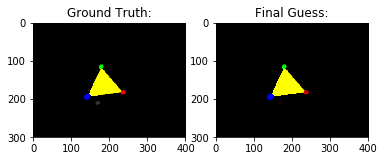

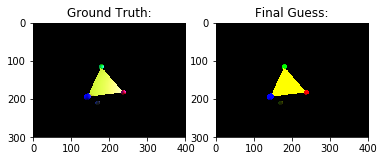

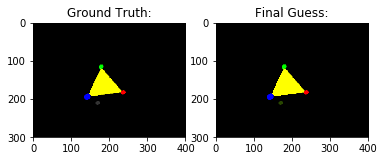

In [89]:
true_image.show_image('albedo', title='Ground Truth:', subplot='121')
flat_renderer.forward().show_image('albedo', title='Final Guess:', subplot='122')
plt.show()

true_phong_image.show_image('albedo', title='Ground Truth:', subplot='121')
phong_renderer.forward().show_image('albedo', title='Final Guess:', subplot='122')
plt.show()

true_image.show_image('albedo', title='Ground Truth:', subplot='121')
flat_renderer_sub.forward().show_image('albedo', title='Final Guess:', subplot='122')
plt.show()